In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

2023-05-31 20:17:12.168354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cargar el dataset
fichero_DemandaDiaria = "/Users/administrador/Desktop/Ingenieria Informatica UPSA/Curso 3/Prediccion Demanda Electrica/Datos/DemandaDiaria_KWh_2015-2021.csv"
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
data['Date'] = pd.to_datetime(data['Date'])  # Convertir la columna de fecha a tipo datetime
data = data.set_index('Date')  # Establecer la columna de fecha como índice

# Preprocesamiento de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Crear secuencias de entrenamiento
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(len(dataset) - sequence_length):
        X.append(dataset[i:i + sequence_length, 0])
        y.append(dataset[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10  # Longitud de la secuencia de entrada
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [3]:
# Reshape para que coincida con la entrada requerida por la CNN (número de muestras, longitud de secuencia, número de características)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [4]:
# Construir el modelo de la CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [5]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
128/128 [==============================] - 1s 1ms/step - loss: 0.0355
Epoch 2/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 3/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 4/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 5/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 6/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 7/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 8/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 9/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 10/10
128/128 [==============================] - 0s 1ms/step - loss: 0.0055


In [7]:
# Realizar predicciones
predictions = model.predict(X_test)

# Revertir la escala de los datos
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mrae = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MRAE:", mrae)

# Comparar las predicciones con los valores reales
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
print(comparison)

16/16 [==============================] - 0s 1ms/step
MAE: 185889897.0756972
RMSE: 280572583.5084184
MRAE: 2.8300332979416924
           Actual     Predicted
0    6.405322e+09  6.334026e+09
1    6.650659e+09  6.475084e+09
2    6.815636e+09  6.478982e+09
3    6.853668e+09  6.643028e+09
4    6.938721e+09  6.720057e+09
..            ...           ...
497  6.194367e+09  6.375432e+09
498  6.255634e+09  6.432617e+09
499  6.189154e+09  6.374090e+09
500  6.148809e+09  6.138297e+09
501  5.721799e+09  5.721564e+09

[502 rows x 2 columns]


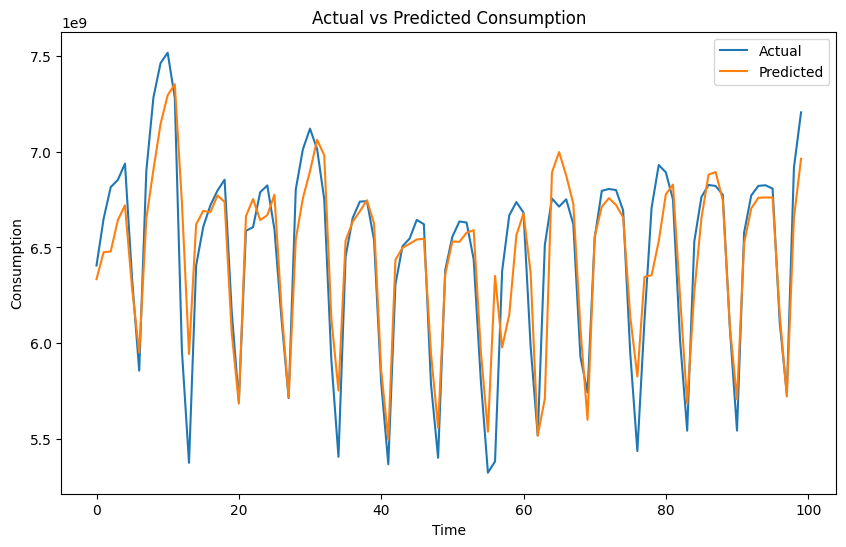

In [9]:
import matplotlib.pyplot as plt

# ...

# Comparar las predicciones con los valores reales
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})

# Obtener un rango más pequeño para el gráfico
start_index = 0  # Índice de inicio del rango
end_index = 100  # Índice de fin del rango

# Grafica con los valores reales vs los valores predichos en el rango especificado
plt.figure(figsize=(10, 6))
plt.plot(comparison.index[start_index:end_index], comparison['Actual'].values[start_index:end_index], label='Actual')
plt.plot(comparison.index[start_index:end_index], comparison['Predicted'].values[start_index:end_index], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Consumption')
plt.legend()
plt.show()
